In [1]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.callbacks import LambdaCallback
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import time, random
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
def baseAutoencoder(shape=(112,80,1)):
    img_input = Input((shape))

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input)
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x) # передаём на слой подвыборки, снижающий размерность поступивших на него данных

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # пропускаем через слой нормализации данных 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)  # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных
    z = MaxPooling2D()(x) # передаём на слой подвыборки
    

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z) # слой разжимает данные(с 28*20 на 56*40)
    x = BatchNormalization()(x) # слой нормализации данных
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    # Сжатие MaxPooling2D не применяем

    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) # слой разжимает данные(с 56*40 на 112*80)
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных

    # Финальный слой двумерной свертки, выдающий итоговое изображение
    x = Conv2D(shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) # указываем модель, с оригинальным изображением на входе в сеть и сжатым-разжатым на выходе из сети
    model.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error') # компилируем модель с оптимайзером Адам и среднеквадратичной ошибкой

    return model

In [3]:
def plotImages(xTrain, pred, shape=(112, 80)): # создадим функцию для вывода изображений как картинок
  n = 5  # количество картинок, которые хотим показать
  plt.figure(figsize=(14, 7)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n(5)
      index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки из тестового набора
      ax = plt.subplot(2, n, i + 1) # выведем область рисования Axes
      plt.imshow(xTrain[index].reshape(shape)) # отрисуем правильные картинки в размере 112*80      
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(pred[index].reshape(shape)) # отрисуем обработанные сеткой картинки в размере 112*80     
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.show()

In [4]:
# Функция для расчета mse
def getMSE(x1, x2): # создадим функцию среднеквадратичной ошибки
  x1 = x1.flatten() # сплющиваем в одномерный вектор
  x2 = x2.flatten() # сплющиваем в одномерный вектор
  delta = x1 - x2 # находим разницу
  return sum(delta ** 2) / len(delta) # и возвращаем сумму квадратов разницы, делённую на длину разницы

In [5]:
# Зададим пару массивов и проверим работу функции
x1 = np.array([1, 1, 1]) # создаем первый массив
x2 = np.array([1, 1, 1]) # создаем второй массив
print(getMSE(x1,x2)) # выведем ошибку полученную нашей функцией

0.0


In [6]:
# Зададим пару массивов и проверим работу функции
x1 = np.array([1, 1, 1, 1]) # создаем первый массив
x2 = np.array([1, 1, 0, 0]) # создаем второй массив
print(getMSE(x1,x2)) # выведем ошибку полученную нашей функцией

0.5


In [7]:
# Загрузим данные из fashion_mnist - базы с одеждой,обувью и т.п
(xTrainMnistF, yTrainMnistF), (xTestMnistF, yTestMnistF) = fashion_mnist.load_data()
xTrainMnistF = xTrainMnistF.astype('float32')/255 # представляем в виде значений от 0 до 1
xTrainMnistF = xTrainMnistF.reshape(xTrainMnistF.shape[0], 28, 28, 1) # меняем форму, приводим к нужным нам размера

4431872/4422102 [==============================] - 0s 0us/step


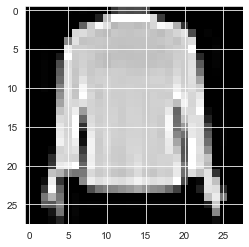

In [9]:
# Взглянем на пример изображения из базы fashion_mnist
n = 169 # выбираем картинку
plt.imshow(xTrainMnistF[n].reshape((28,28)), cmap='gray') # переводим в 4х-канальное цветовое пространство RGBA
plt.show() # покажем картинку

In [11]:
modelAutoMnist = baseAutoencoder((28,28,1)) # создаем автокодировщик

C:\Users\xande\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [15]:
(xTrainMnist, yTrainMnist), (xTestMnist, yTestMnist) = mnist.load_data() # загружаем данные из базы с разбивкой на train/test
xTrainMnist = xTrainMnist.astype('float32')/255 # представляем в виде значений от 0 до 1
xTrainMnist = xTrainMnist.reshape(-1, 28, 28, 1) # меняем форму, приводим к нужным нам размерам
xTestMnist = xTestMnist.astype('float32')/255 # представляем в виде значений от 0 до 1
xTestMnist = xTestMnist.reshape(-1, 28, 28, 1) # меняем форму, приводим к нужным нам размерам

11501568/11490434 [==============================] - 1s 0us/step


In [16]:
xTrainMnist.shape # Отобразим размерность массива xTrainMnist

(60000, 28, 28, 1)

In [18]:
# Обучаем модель автокодировщика
history = modelAutoMnist.fit(xTrainMnist, xTrainMnist, epochs=100, batch_size=256, validation_data = (xTestMnist, xTestMnist))

Epoch 1/100
235/235 [==============================] - 12s 44ms/step - loss: 0.0678 - val_loss: 0.0971
Epoch 2/100
235/235 [==============================] - 10s 41ms/step - loss: 0.0142 - val_loss: 0.0141
Epoch 3/100
235/235 [==============================] - 10s 40ms/step - loss: 0.0085 - val_loss: 0.0069
Epoch 4/100
235/235 [==============================] - 10s 41ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 5/100
235/235 [==============================] - 10s 42ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 6/100
235/235 [==============================] - 10s 41ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 7/100
235/235 [==============================] - 10s 41ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 8/100
235/235 [==============================] - 10s 41ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 9/100
235/235 [==============================] - 10s 41ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 10/100
235/235 [==============================] - 9s 40ms/step - lo

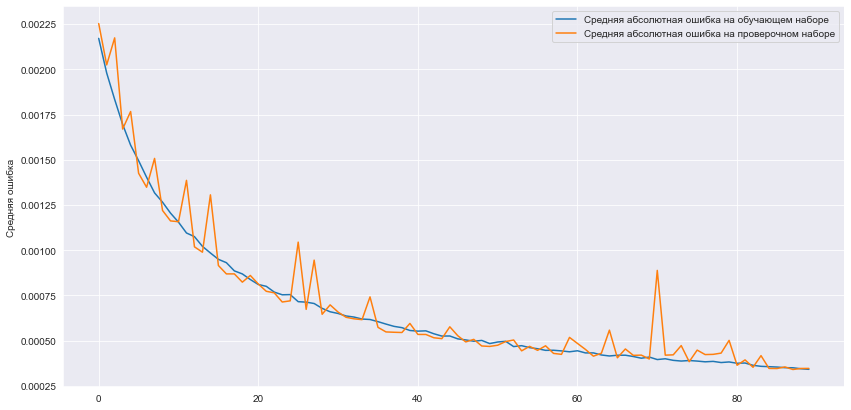

In [19]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][10:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][10:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [20]:
modelAutoMnist.save_weights('./modelAutoMnist.h5') # Сохраняем модель
modelAutoMnist.load_weights('./modelAutoMnist.h5') # Загружаем модель

In [21]:
predMnistTest = modelAutoMnist.predict(xTestMnist) # Получаем результат работы модели на тестовой выборке
predMnistTest = predMnistTest * 255 # представляем в виде значений от 0 до 255
predMnistTest = predMnistTest.astype('uint8') # устанавливаем 8битовый тип

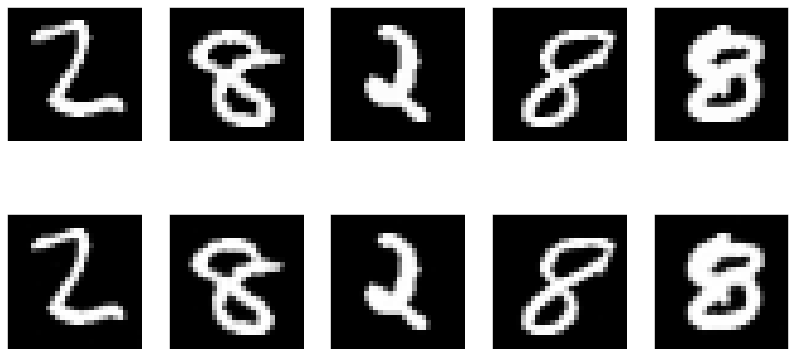

In [22]:
plotImages(xTestMnist, predMnistTest, shape=(28,28)) # покажем исходные и восстановленные картинки

In [23]:
predMnistTrain = modelAutoMnist.predict(xTrainMnist) # Получаем результат работы модели на обучающей выборке
predMnistTrain = predMnistTrain * 255 # представляем в виде значений от 0 до 255
predMnistTrain = predMnistTrain.astype('uint8') # устанавливаем 8битовый тип

In [12]:
predMnistF = modelAutoMnist.predict(xTrainMnistF) # сделаем предикт для первых ста картинок из fashion_mnist
predMnistF = predMnistF * 255 # представляем в виде значений от 0 до 255
predMnistF = predMnistF.astype('uint8') # устанавливаем 8битовый тип

In [ ]:
plotImages(xTrainMnistF, predMnistF, shape=(28,28)) # выведем на экран картинки правильных и восстановленных изображений 